In [5]:
from scipy.stats import norm
class ModelClass:
  def __init__(self, model_parameters):
    self.model_name = model_parameters[0]
    print(self.model_name)

    if self.model_name == 'GBM_MV':
      self.B = model_parameters[1]
      self.sigma = model_parameters[2]
      self.r = model_parameters[3]
      self.x0 = model_parameters[4]
      self.h = model_parameters[5]
      self.b = self.B + self.r


#    if self.model_name == 'GBM_options':
#      self.b = model_parameters[1]
#      self.sigma = model_parameters[2]
#      self.r = model_parameters[3]
#      self.x0 = model_parameters[4]
#      self.h = model_parameters[5]
#      self.T = model_parameters[6]

  def F_x(self, x, u, dW, Y, bankrupcy_constraint, jumps):
    x_kp1 = None
    M = dW.shape[0]
    if self.model_name == 'GBM_MV':
      # update-rule x_{k+1} = x_k + b(t,x_k,u_k)h + sigma(t,x_k,u_k)dW_k
      if bankrupcy_constraint:
        bc = tf.where(x > 0, 1., 0.)
        x_kp1 = x + bc*((self.r*x + tf.matmul(u, tf.transpose(self.B)))*self.h + tf.reshape(tf.reduce_sum(tf.matmul(u, self.sigma)*dW, axis=1), [M,1]))
      else:
        x_kp1 = x + (self.r*x + tf.matmul(u, tf.transpose(self.B)))*self.h + tf.reshape(tf.reduce_sum(tf.matmul(u, self.sigma)*dW, axis=1), [M,1])
      if jumps:
        sum_Y = tf.reshape(tf.reduce_sum(u*Y,1),x_kp1.shape) # since u=N*S, tis implies that the jumps a multiplicative wrt. the stock process
        if bankrupcy_constraint:
          bc = tf.where(x > 0, 1., 0.)
          x_kp1 = x_kp1 + bc*sum_Y
        else:
          x_kp1 = x_kp1 + sum_Y


    return x_kp1

  def F_x_np(self, x, u, dW, Y, bankrupcy_constraint, jumps):
    x_kp1 = None
    M = dW.shape[0]
    if self.model_name == 'GBM_MV':
      # update-rule x_{k+1} = x_k + b(t,x_k,u_k)h + sigma(t,x_k,u_k)dW_k
      if bankrupcy_constraint:
        bc = np.where(x > 0, 1., 0.)
        x_kp1 = x + bc*((self.r*x + np.matmul(u, np.transpose(self.B)))*self.h + np.reshape(np.sum(np.matmul(u, self.sigma)*dW, axis=1), [M,1]))
      else:
        x_kp1 = x + (self.r*x + np.matmul(u, np.transpose(self.B)))*self.h + np.reshape(np.sum(np.matmul(u, self.sigma)*dW, axis=1), [M,1])
      if jumps:
        sum_Y = np.reshape(np.sum(u*Y,1),x_kp1.shape)
        if bankrupcy_constraint:
          bc = np.where(x > 0, 1., 0.)
          x_kp1 = x_kp1 + bc*sum_Y
        else:
          x_kp1 = x_kp1 + sum_Y

    return x_kp1



  def u(self, alpha, P, x):
    a = tf.multiply(tf.nn.softmax(alpha*P[:,1:]), x)  # scale to prevent leverage
    aa = np.zeros([P.shape[0],1])
    aa[:,0] = 1
    #aa[:,2:]  = 1
    bb = tf.constant(aa, dtype=tf.float32)
    u = tf.multiply(alpha, bb)#
    return u



  # Bond #
  def Bond(self, n):
    B_kp1 = np.exp(self.r*self.h*n)
    return B_kp1
  ###

  # Stock #
  def F_S(self, S, dW, Y, jumps):
    #S_kp1 = S*tf.exp((self.b - self.sigma**2/2)*self.h + self.sigma*dW)
    tr_sig2 = tf.linalg.diag(tf.reduce_sum(self.sigma*self.sigma, 1))
    tr_sig2_rd = tf.matmul(tf.ones(S.shape), tr_sig2)
    S_kp1 = S*tf.exp( (self.b - tr_sig2_rd/2)*h + tf.matmul(dW, tf.transpose(self.sigma)) )
    if jumps:
      S_kp1 = S_kp1 + Y*S_kp1
    return S_kp1
  ###

    # Stock #
  def F_S_jump(self, S, dW, Y, jumps):
    #S_kp1 = S*tf.exp((self.b - self.sigma**2/2)*self.h + self.sigma*dW)
    tr_sig2 = tf.linalg.diag(tf.reduce_sum(self.sigma*self.sigma, 1))
    tr_sig2_rd = tf.matmul(tf.ones(S.shape), tr_sig2)
    S_kp1 = S + self.b*h + tf.matmul(dW, tf.transpose(self.sigma))
    if jumps:
      S_kp1 = S_kp1 + Y*S_kp1
    return S_kp1
  ###

  def F_S_np(self, S, dW, Y, jumps):
    #S_kp1 = S*tf.exp((self.b - self.sigma**2/2)*self.h + self.sigma*dW)
    tr_sig2 = np.diag(np.sum(self.sigma*self.sigma, 1))
    tr_sig2_rd = np.matmul(np.ones(S.shape), tr_sig2)
    S_kp1 = S*np.exp( (self.b - tr_sig2_rd/2)*h + np.matmul(dW, np.transpose(self.sigma)) )
    if jumps:
      S_kp1 = S_kp1 + Y*S_kp1
    return S_kp1
  ###

  # Call/Put options #
  def CPu(self, S, K, T, n):
    S0 = S
    sig = np.sqrt(np.sum(self.sigma.numpy().astype('float64')**2, 1))
    d1 = 1/(sig*np.sqrt(T - n*self.h))*( np.log(S/K) + (self.r+sig**2/2)*(T - n*self.h))
    d2 = d1 - sig*np.sqrt(T - n*self.h)
    C = norm.cdf(d1)*S -  norm.cdf(d2)*K*np.exp(-self.r*(T-n*self.h))
    P = K*np.exp(-self.r*(T-n*self.h)) - S + C
    return C, P

  def CP(self, S, K, T, n):
    tfd = tfp.distributions
    normal = tfd.Normal(loc=0.0, scale=1.0)
    S0 = S
    sig = tf.sqrt(tf.reduce_sum(self.sigma**2, 1))
    sqrt = tf.cast(tf.sqrt(T - n*self.h), tf.float32)
    disc = tf.cast(tf.exp(-self.r*(T-n*self.h)), tf.float32)
    #print('sig: ', sig)
    d1 = 1/(sig*sqrt)*( tf.math.log(S/K) + (self.r+sig**2/2)*(T - n*self.h))
    d2 = d1 - sig*sqrt
    C = normal.cdf(d1)*S -  normal.cdf(d2)*K*disc
    P = K*disc - S + C
    return C, P

  ###


















In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import random
import tensorflow as tf
tf.keras.backend.set_floatx('float32')




############## Define Neural Network Classes ##############

class SubNetwork(tf.keras.Model):
    def __init__(self, d, regularization=1e-6, neurons=[16,16,16], activation='relu'):
        super(SubNetwork, self).__init__()

        self.neurons = neurons
        self.activation = activation

        self.d = d
        #Define l2 regularization.
        self.regularization = regularization
        regu = tf.keras.regularizers.l2(self.regularization)


        # Define layers
        self.dense_layers = []
        self.batch_norm = []
        for i in range(len(self.neurons)):
            self.dense_layers.append(tf.keras.layers.Dense(self.neurons[i],
                                                    activation=self.activation,
                                                    use_bias=True,
                                                    kernel_regularizer=regu))
            self.batch_norm.append(tf.keras.layers.BatchNormalization())


        # Define output layer
        self.dense_out = tf.keras.layers.Dense(self.d,
                                               activation='linear', #'softplus', #
                                               use_bias=True,
                                               kernel_regularizer = None)

    def call(self, x_in):
        """Forward propagation"""
        x = x_in
        for i in range(len(self.neurons)):
            x = self.dense_layers[i](x)
            x = self.batch_norm[i](x)
        x = self.dense_out(x)
        return x


class FullNetwork(tf.keras.Model):
    def __init__(self, d, l, regularization, neurons, N, NN, h, activation):
        super(FullNetwork, self).__init__()

        self.network_u = []
        self.NN = NN
        self.N = N
        self.diff = int(NN/N)
        self.h = h
        self.d = d
        self.dim = d
        self.network_u.append(SubNetwork(d=self.dim, regularization=None,
                                   neurons=[],
                                   activation='linear'))
        for _ in range(self.N):
          self.network_u.append(SubNetwork(d=self.d, regularization=regularization,
                                   neurons=neurons,
                                   activation=activation))

        self.network_options = SubNetwork(d=2*self.dim + 1, regularization=None,
                                   neurons=[],
                                   activation='linear')
        self.network_K = SubNetwork(d=2*self.dim, regularization=None,
                                   neurons=[],
                                   activation='linear')


    def call(self, x_in):
        """Forward propagation"""
        x = x_in
        #K_options = self.network_options(x)
        alpha_options = tf.nn.softmax(self.network_options(x))[:,:2*self.d]
        alpha_options_tot = tf.reduce_mean(tf.reduce_sum(alpha_options, 1))
        K = 1. + 0.25*tf.nn.tanh(self.network_K(x))
        rescale = 1. - alpha_options_tot
        alpha = self.network_u[0](x)#
        x0 = x[:,:]

        S = S0
        S_Q = tf.ones([batch_size,d])
        P = np.ones([M,d,N+1])
        delta_N_acu = 0.


        for n in range(1, self.NN+1):
          if model_name == 'GBM_MV':

            if leverage_constraints:
              u = model.u(alpha, P, x)
            else:
              u = alpha[:,:]#tf.nn.softplus(alpha[:,:])
            if n > 1:
              N_p = tf.multiply(u, 1/S)
              delta_N = N_p - N_m1
              delta_N_acu = delta_N_acu + tf.abs(delta_N)
            N_m1 = tf.multiply(u, 1/S)

            if jumps:
              Z = tf.random.poisson([batch_size,d], lamb)
              Y = tf.random.normal(Z.shape, mean=mu*tf.cast(Z, tf.float32), stddev=tf.sqrt(tf.cast(Z, tf.float32))*s)

            else:
              Y = np.zeros([batch_size,d])

            dW = tf.random.normal(S.shape, mean=0, stddev=np.sqrt(self.h))
            x = model.F_x(x, u, dW, Y, bankrupcy_constraint, jumps)

            P[:,0] = model.Bond(n)
            S = model.F_S(S, dW, Y, jumps)
            S_Q = model_2.F_S(S_Q, dW, Y, jumps)

            if n == 5:
              x_5 = x[:,:]
              alpha_5 = alpha[:,:]

#          if model_name == 'GBM_options':

#            dW = np.sqrt(self.h)*np.random.normal(0, 1, [batch_size])
#            P1[:,0] = model.Bond(n)
#            P1[:,1] = model.F_S(P0[:,1], dW)
#            P1[:,2], P1[:,3] = model.CP(P1[:,1], K, T, n)
#            P1[:,2] = P1[:,2]/Call_0
#            P1[:,3] = P1[:,3]/Put_0

#            Delta_P = P1-P0
#            print('n: ', n, 'Delta_P: ', np.mean(Delta_P[:,1]))
#            dPoP = Delta_P[0,0]/P0[0,0]

#            x = model.F_x(x, u, Delta_P, dPoP, P0, dW)

#            P0[:,:] = P1[:,:]
            #print('n: ', n, 'E[P]: ', np.mean(P0, 0), 'E[S]: ', np.exp(n*h*0.12))
            #print('n: ', n, 'Var[P1]: ', np.var(P0[:,1]), 'Var[S]: ', np.exp(2*n*h*0.12)*(np.exp(sigma**2*n*h) - 1))

          if np.remainder(n,self.diff)==0:
            if  n<self.NN:
              alpha = self.network_u[int(n/self.diff)](x)

        delta_N_acu =  tf.reshape(tf.reduce_sum(delta_N_acu,1), x.shape) # delta_u_acu[:,0:1] + delta_u_acu[:,1:2] #
        C_0, P_dummy = model.CP(S0_np, K[:,:self.d], T, 0)
        C_dummy, P_0 = model.CP(S0_np, K[:,self.d:], T, 0)

        C_0_MC = tf.matmul(tf.ones([batch_size,1]), tf.reshape(tf.exp(-r*T)*tf.reduce_mean(tf.maximum(S_Q - K[:,:self.d], 0), 0), [1,d]))
        P_0_MC = tf.matmul(tf.ones([batch_size,1]), tf.reshape(tf.exp(-r*T)*tf.reduce_mean(tf.maximum(K[:,self.d:] - S_Q, 0), 0), [1,d]))

        #C_T = tf.maximum(S - K[:,:self.d], 0)/C_0
        #P_T = tf.maximum(K[:,self.d:] - S, 0)/P_0
        C_T = tf.maximum(S - K[:,:self.d], 0)/C_0_MC
        P_T = tf.maximum(K[:,self.d:] - S, 0)/P_0_MC

        x_T = x[:,:]
        #payoff = alpha_options[:,0:1]*C_T[:,0:1] + alpha_options[:,1:2]*C_T[:,1:2] + alpha_options[:,2:3]*C_T[:,2:3] + alpha_options[:,3:4]*C_T[:,3:4] + alpha_options[:,4:5]*C_T[:,4:5] + alpha_options[:,5:6]*P_T[:,0:1] + alpha_options[:,6:7]*P_T[:,1:2] + alpha_options[:,7:8]*P_T[:,2:3] + alpha_options[:,8:9]*P_T[:,3:4] + alpha_options[:,9:10]*P_T[:,4:5] #+ alpha_options[:,2:3]*P_T[:,0:1] + alpha_options[:,3:4]*P_T[:,1:2]
        if options_in_p:
          payoff = tf.reshape(tf.math.reduce_sum(alpha_options[:,:self.d]*C_T, 1), x.shape) + tf.reshape(tf.math.reduce_sum(alpha_options[:,self.d:]*P_T, 1), x.shape) #tf.reduce_sum(tf.multiply(alpha_options[:,:self.d], C_T), 1)# + tf.multiply(alpha_options[:,self.d:], P_T), 1)
          x = rescale*x - curtage*rescale*delta_N_acu + payoff
        else:
          x = x - curtage*delta_N_acu

        loss1 = -tf.reduce_mean(x)
        loss2 = tf.math.reduce_variance(x) # tf.reduce_mean(x**2)-(tf.reduce_mean(x))**2 #
        loss3 = -tf.reduce_mean(x[x < tfp.stats.percentile(x, 5)]) #-tf.reduce_mean(x[x < tfp.stats.percentile(x, 5)])
        loss4 = -tf.reduce_mean(x[x > tfp.stats.percentile(x, 95)])
        loss5 = tf.reduce_mean(C_T[:,0])
        loss6 = tf.math.reduce_mean(K[0,1])
        loss7 = tf.math.reduce_mean(rescale)
        #-tf.reduce_mean(x[x > tfp.stats.percentile(x, 95)])
        return (tf.expand_dims(loss1, 0), tf.expand_dims(loss2, 0),
        tf.expand_dims(loss3, 0), tf.expand_dims(loss4, 0),
        tf.expand_dims(loss5, 0), tf.expand_dims(loss6, 0),
        tf.expand_dims(loss7, 0))



In [ ]:
############################################################

############## Create and Train Network  ##############


regularization = 0#1e-6 # L2 regularization
num_epochs = 12# LQR 15 # Number of epochs
batch_size = 2**16# LQR 2**9 # Batch_size
activation = 'relu' # 'softplus' # Activation
neurons =  [20,20] # LQR [20,20,20] # number of neurons in each layer
learning_rate = 0.01 # LQR 0.01 # Learning rate

M = 2**22 #LQR 2 ** 21
N = 20 # allocation dates
NN = N # Time points in discrete approximation
T = 2.
d = 5
l = d
t = np.linspace(0,T,NN+1)
h = t[1]-t[0]
x0 = np.random.uniform(low=1., high=1., size = [M,1])
S0 = tf.ones([batch_size,d])
S0_np = S0.numpy()
model_name = 'GBM_MV'
curtage = 0.0
leverage_constraints = False
options_in_p = False
bankrupcy_constraint = False
jumps = False



if model_name == 'GBM_MV' or model_name == 'GBM_options':
  r = 0.06
  ExT = 1.2 #
  b = tf.reshape(tf.linspace(0.08, 0.04, d), [d,1]) #tf.reshape(tf.linspace(0.12, 0.07, d), [d,1]) # tf.constant([[0.12]]) #
#tf.constant([[0.12], [0.1175], [0.115], [0.11], [0.1075], [0.1050], [0.1025], [0.1000], [0.0975], [0.0950], [0.0925], [0.09], [0.0875], [0.0850], [0.0825], [0.08], [0.0775], [0.0750], [0.0725], [0.07]]) # tf.constant([[0.12], [0.1]]) # tf.constant([[0.12]]) #
  B = tf.transpose(b)-r
  sigma = 0.15


  if model_name == 'GBM_MV':
    # jump parameters
    lamb = 0.05
    mu = -0.0
    s = 0.2
    ###
    sigma = tf.linalg.diag(tf.linspace(0.18, 0.12, d)) + 0.05*(tf.ones([d,d])) - tf.constant([[0., 0., 0.1, 0., 0.], [0., 0., 0., 0., 0.],[.1, 0., 0., .0, .0], [0., 0.,.0, 0., 0.],[0., 0., 0., 0., 0.]]) # tf.constant([[.15]]) #
#tf.linalg.diag([.15,.144,.14,.135,.13,.125,.12,.115,.11,.105,.1,.095,.09,.085,.08,.075,.07,.065,.06,.055]) + 0.05*tf.ones([d,d]) #tf.constant([[.15, .05], [.05, .1]]) # tf.constant([[.15]]) #
    sig_inv = tf.linalg.inv(tf.matmul(sigma, tf.transpose(sigma)))
    rho = tf.matmul(tf.matmul(B, sig_inv), tf.transpose(B))[0,0]
    gamma = 1/(1 - np.exp(-rho*T))*(ExT - np.exp((r - rho)*T))
    varxT = np.exp(-rho*T)/(1 - np.exp(-rho*T))*(ExT - x0[0,0]*np.exp(r*T))**2
    lam = 1/(2*(gamma - ExT))
    print('ExT: ', ExT, 'VarxT: ', varxT, 'lambda: ', lam, 'Optimal loss: ', -ExT + lam*varxT)
    model_parameters = [model_name, B, sigma, r, x0, h, T]
    model_2_parameters = [model_name, B - B, sigma, r, x0, h, T]





model = ModelClass(model_parameters)
model_2 = ModelClass(model_2_parameters)


# Create the full NN
full_model = FullNetwork(d=d, l=l, regularization=regularization,neurons=neurons, N = N, NN=NN, h=h, activation=activation)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

def dummy_loss(y_target,y_pred):
  return y_pred


loss_list = [dummy_loss, dummy_loss, dummy_loss, dummy_loss, dummy_loss, dummy_loss, dummy_loss]#{'loss':'MSE', 'dummy_loss':dummy_loss}


#Compile network
full_model.compile(optimizer=optimizer, loss=loss_list, loss_weights=[1., lam, 0, 0, 0, 0, 0])#[1., 0.5*lam, 0.25*lam, 0.1*lam, .0, 0., 0.])

# Define zero vector
zero_vec = np.zeros(x0.shape)

#Train network using model.fit
def scheduler0(epoch, lr):
  if epoch < 2:
    return float(lr)
  else:
    return float(lr * tf.exp(-0.5 * epoch))  # Pre-computed value of exp(-0.5)
def scheduler1(epoch, lr):
  if epoch < 2:
    return float(lr*0.1)
  else:
    return float(lr * tf.math.exp(-0.5))
callback = tf.keras.callbacks.LearningRateScheduler(scheduler0)



history = full_model.fit(x0, [zero_vec, zero_vec, zero_vec, zero_vec, zero_vec, zero_vec, zero_vec], epochs=num_epochs, batch_size=batch_size, callbacks=[callback], verbose=1)
train_loss = history.history['loss']
plt.figure()
plt.plot(train_loss,'.-',linewidth=2)
#plt.yscale('log')
plt.grid()
plt.title('Train Loss')
plt.xlabel('Epoch')
plt.show()


count = 0
if model_name == 'GBM_options':
  count = 1

ExT:  1.2 VarxT:  0.0328361728342632 lambda:  1.1040132 Optimal loss:  -1.16374843160328
GBM_MV
GBM_MV
Epoch 1/12


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'full_network', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


NameError: name 'x' is not defined

In [ ]:
mean_xT = tf.reduce_mean(x)
var_xT = tf.math.reduce_variance(x)
print("Sample mean: ", mean_xT.numpy())
print("Sample var: ", var_xT.numpy())
print("Objective: ", -mean_xT + lam * var_xT)


In [ ]:
from scipy.special import softmax
from scipy.stats import poisson

# to control target mean of MV-strategy
control_target = True
if control_target:
  ExT =  1.1725
  gamma =  1/(1 - np.exp(-rho*T))*(ExT- np.exp((r - rho)*T))
  varxT = np.exp(-rho*T)/(1 - np.exp(-rho*T))*(ExT - x0[0,0]*np.exp(r*T))**2
  lam_0 = 1/(2*(gamma - ExT))


no_control = False
M = 2**18
x = np.zeros([M,1,NN+1])
S = np.ones([M,d,NN+1])
S_Q = np.ones([M,d,NN+1])
x_ref = np.zeros(x.shape)
x[:,:,0] = np.random.uniform(low=1.0, high=1.0, size = [M,1])
x_ref[:,:,0] = x[:,:,0]
dW = np.sqrt(h)*np.random.normal(0, 1, [M, d, NN])

K = 1 + 0.25*tf.nn.tanh(full_model.network_K.predict(x[:,:,0], batch_size=M))

if count==0:
  count += 1
  sigma = sigma.numpy().astype('float64')
  B = B.numpy().astype('float64')
  rho = rho.numpy().astype('float64')
  sig_inv = sig_inv.numpy().astype('float64')
  model_parameters =  [model_name, B, sigma, r, x0, h, T]
  model_2_parameters = [model_name, B - B, sigma, r, x0, h, T]

  S0_eval = S[:,:,0]

  #K = K[0,0]*np.ones(S0_eval.shape)
  diff = int(NN/N)
  C_0, P_dummy = model.CP(S0_eval, K[:,:d], T, 0)
  C_dummy, P_0 = model.CP(S0_eval, K[:,d:], T, 0)

K = 1 + 0.25*tf.nn.tanh(full_model.network_K.predict(x[:,:,0], batch_size=M))
model = ModelClass(model_parameters)
model_2 = ModelClass(model_2_parameters)


u = np.zeros([M, l, N])
u_ref_x = np.zeros([M, l, N])
u_ref_x_ref = np.zeros([M, l, N])



print('0: ', 0)
#if model_name == 'GBM_options':
#  B = b - r
#  P = np.zeros([M, 4, N+1])
#  dW = np.random.normal(0, np.sqrt(h), [M]) #tf.random.normal([batch_size], mean=0, stddev=np.sqrt(self.h))
#  P[:,0,0] = model.Bond(0)
#  P[:,1,0] = S0[0,0]
#  P[:,2,0], P[:,3,0] = 1, 1 # scale option price at t=0 to 1

#  if leverage_constraints:
#    u[:,:,0] = model.u(alpha, P[:,:,0], x[:,:,0])
#  else:
#    u = alpha[:,:]

#  u_ref_x_ref[:,:,0] = (gamma*np.exp(-r*(T - t[0])) - x_ref[:,:,0])*sig_inv*B/P[:,1:2,0]



if model_name == 'GBM_MV':
  alpha_options = softmax(full_model.network_options.predict(x[:,:,0], batch_size=M), 1)[:,:2*d] #full_model.network_options.predict(x[:,:,0], batch_size=M)
  alpha_options_tot = np.mean(np.sum(alpha_options, 1))
  rescale = 1 - alpha_options_tot
  u[:,:,0] = full_model.network_u[0].predict(x[:,:,0], batch_size=M)

  uu = u[:,:,0]
  u_ref_x[:,:,0] = np.matmul(gamma*np.exp(-r*(T - t[0])) - x[:,:,0], np.transpose(tf.matmul(sig_inv, np.transpose(B))))
  u_ref_x_ref[:,:,0] = np.matmul(gamma*np.exp(-r*(T - t[0])) - x_ref[:,:,0], np.transpose(tf.matmul(sig_inv, np.transpose(B))))
  uu_ref_x_ref = u_ref_x_ref[:,:,0]
  Z_np = poisson.rvs(lamb, size=[M,d])
  Y_np = np.random.normal(mu*Z_np, np.sqrt(Z_np)*s,  size = [M,d])
  x[:,:,1] = model.F_x_np(x[:,:,0], uu, dW[:,:,0], Y_np, bankrupcy_constraint, jumps)
  x_ref[:,:,1] = model.F_x_np(x_ref[:,:,0], uu_ref_x_ref, dW[:,:,0], Y_np, bankrupcy_constraint, jumps)

  delta_u_acu = 0.
  delta_u_acu_ref = 0.



for n in range(1,NN+1):
  if model_name == 'GBM_MV':
    S[:,:,n] = model.F_S_np(S[:,:,n-1], dW[:,:,n-1], Y_np, jumps)
    S_Q[:,:,n] = model_2.F_S_np(S_Q[:,:,n-1], dW[:,:,n-1], Y_np, jumps)

    if n<NN:
      if np.remainder(n,diff)==0:
        print('n: ', n)
        u[:,:,int(n/diff)] = full_model.network_u[int(n/diff)].predict(x[:,:,n], batch_size=M)



      u_ref_x[:,:,int(n/diff)] = np.matmul(gamma*np.exp(-r*(T - t[n])) - x[:,:,n], np.transpose(np.matmul(sig_inv, np.transpose(B))))


      u_ref_x_ref[:,:,int(n/diff)] = np.matmul(gamma*np.exp(-r*(T - t[n])) - x_ref[:,:,n], np.transpose(np.matmul(sig_inv, np.transpose(B))))
      uu = u[:,:,int(n/diff)]
      uu_ref_x_ref = u_ref_x_ref[:,:,int(n/diff)]
      Z_np = poisson.rvs(lamb, size=[M,d])
      Y_np = np.random.normal(mu*Z_np, np.sqrt(Z_np)*s,  size = [M,d])
      x[:,:,n+1] = model.F_x_np(x[:,:,n], uu, dW[:,:,n], Y_np, bankrupcy_constraint, jumps)
      x_ref[:,:,n+1] = model.F_x_np(x_ref[:,:,n], uu_ref_x_ref, dW[:,:,n], Y_np, bankrupcy_constraint, jumps)



u0 = x[:,0,:-1] - np.sum(u,1) # amount of bond at each time point
u0_ref = x_ref[:,0,:-1] - np.sum(u_ref_x_ref,1)

C_0_MC = np.matmul(tf.ones([M,1]), tf.reshape(tf.exp(-r*T)*np.mean(np.maximum(S_Q[:,:,-1] - K[:,:d], 0), 0), [1,d]))
P_0_MC = np.matmul(tf.ones([M,1]), tf.reshape(tf.exp(-r*T)*np.mean(np.maximum(K[:,d:] - S_Q[:,:,-1], 0), 0), [1,d]))

C_T = np.maximum(S[:,:,-1] - K[:,:d], 0)/C_0_MC
P_T = np.maximum(K[:,d:] - S[:,:,-1], 0)/P_0_MC



N_p = u/S[:,:,:-1]
delta_N = N_p[:,:,1:] - N_p[:,:,:-1]
delta_N_acu = np.reshape(np.sum(np.sum(np.abs(delta_N), 1),1), x[:,0:1,-1].shape)

N_p_ref = u_ref_x/S[:,:,:-1]
delta_N_ref = N_p_ref[:,:,1:] - N_p_ref[:,:,:-1]
delta_N_acu_ref = np.reshape(np.sum(np.sum(np.abs(delta_N_ref), 1),1), x_ref[:,0:1,-1].shape)
if options_in_p:
  payoff_call = np.reshape(np.sum(alpha_options[:,:d]*C_T, 1), x[:,:,-1].shape)
  payoff_put = np.reshape(np.sum(alpha_options[:,d:]*P_T, 1), x[:,:,-1].shape)
  payoff = payoff_call + payoff_put
  xN_SB = x[:,0:1,-1]  - curtage*delta_N_acu
  xN_SB = xN_SB[:,0]
  xN = rescale*x[:,0:1,-1] + payoff - curtage*rescale*delta_N_acu # alpha_options[:,0:1]*C_T[:,0:1] + alpha_options[:,1:2]*P_T[:,0:1]
  xN = xN[:,0]
else:
  xN = x[:,0:1,-1]  - curtage*delta_N_acu
  xN = xN[:,0]

xN_ref = x_ref[:,0:1,-1] - curtage*delta_N_acu_ref
xN_ref = xN_ref[:,0]

ES_05 = np.mean(xN[xN < np.percentile(xN, 5)])

print('Ex: ', np.mean(xN), 'Varx: ', np.var(xN), 'cost: ', -np.mean(xN) + lam*np.var(xN))
print('Ex (ref): ', np.mean(x_ref[:,0,-1]), 'Varx (ref): ', np.var(x_ref[:,0,-1]), 'cost (analytic): ', -np.mean(x_ref[:,0,-1]) + lam*np.var(x_ref[:,0,-1]))
print('Ex (ref): ', np.mean(xN_ref), 'Varx (ref): ', np.var(xN_ref), 'cost (analytic): ', -np.mean(xN_ref) + lam*np.var(xN_ref))
print(np.max(u), np.max(u_ref_x_ref))


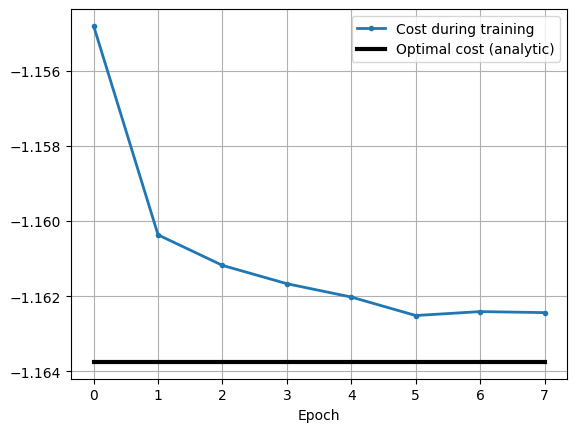

In [ ]:
plt.figure()
plt.plot(train_loss,'.-',linewidth=2)
#plt.yscale('log')
plt.grid()
plt.xlabel('Epoch')
plt.plot([0,num_epochs-1], [-1.1637484124793813, -1.1637484124793813], 'k', linewidth=3)
plt.legend(['Cost during training', 'Optimal cost (analytic)'])
plt.show()

In [ ]:
plt.plot(full_model.network_u[0].predict(x[0:1,:,0], batch_size=1)[0,:], '.')
plt.plot(u_ref_x_ref[0,:,0],'.')
plt.grid()
print('K: ', K[0,:])
print('alpha: ', alpha_options[0,:], 'alpha tot: ', alpha_options_tot)



In [ ]:
import statsmodels.api as sm
ES_05 = np.mean(xN[xN < np.percentile(xN, 5)])
ES_95 = np.mean(xN[xN > np.percentile(xN, 95)])

print('Ex: ', ExT, 'Ex (ref):', np.mean(xN_ref), 'Ex (approx): ', np.mean(xN))
print('Varx: ', varxT, 'Varx (ref):', np.var(xN_ref), 'Varx (approx): ', np.var(xN))
print('Continuous cost: ', -ExT + lam*varxT, 'Ref. cost: ', -np.mean(xN_ref) + lam*np.var(xN_ref), 'Approx. cost: ', -np.mean(xN) + lam*np.var(xN), 'Full cost: ', -np.mean(xN) + lam*np.var(xN) -0.*lam*ES_05  - 0.*lam*ES_95)

plt.plot(t,np.mean(x[:,0,:],0),'b')
plt.plot(t,np.mean(x_ref[:,0,:],0), 'r--')
plt.plot(t, np.percentile(x[:,0,:],95, axis = 0), 'bd-')
plt.plot(t,np.percentile(x_ref[:,0,:],95, axis = 0), 'r.--')


plt.plot(t,np.percentile(x[:,0,:],5, axis = 0), 'bd-')
plt.plot(t,np.percentile(x_ref[:,0,:],5, axis = 0), 'r.--')


plt.ylabel('Wealth')
plt.xlabel('Time')
plt.legend(['E[$x_t$] (approx.)', 'E[$x_t$] (analytic)', '5/95 Percentiles (approx.)', '5/95 Percentiles (analytic)'])
plt.grid()

plt.figure()
nn = 0#int(N/2)
plt.plot(x[:,0,nn], u[:,0,nn],'bo')
plt.plot(x[:,0,nn], u_ref_x[:,0,nn],'r.')
plt.xlabel('Wealth')
plt.ylabel('Allocation to stock')
plt.legend(['Approximate sol', 'Analytical sol'])
plt.grid()

plt.figure()
kk = int(np.random.rand()*M)
plt.plot(t,x[kk,0,:],'b')
plt.plot(t,x_ref[kk,0,:], 'r.--')
plt.plot(t,x[kk+1,0,:],'b')
plt.plot(t,x_ref[kk+1,0,:], 'r.--')
plt.plot(t,x[kk+2,0,:],'b')
plt.plot(t,x_ref[kk+2,0,:], 'r.--')
plt.ylabel('Wealth')
plt.xlabel('Time')
plt.legend(['Approximate sol', 'Analytical sol'])
plt.grid()


plt.figure()
kk = int(np.random.rand()*M)
plt.plot(t[:N],u[kk,0,:N],'b')
plt.plot(t[:N],u_ref_x[kk,0,:N], 'r.--')
if d>1:
  plt.plot(t[:N],np.transpose(u[kk,1:,:N]),'bd')
  plt.plot(t[:N],np.transpose(u_ref_x[kk,1:,:N]), 'r.--')
plt.ylabel('Allocation')
plt.xlabel('Time')
plt.legend(['Approximate sol', 'Analytical sol'])
plt.grid()

plt.figure()
kk = int(np.random.rand()*M)
plt.plot(t[:N],np.mean(u[:,0,:N],0),'bd')
plt.plot(t[:N],np.mean(u_ref_x[:,0,:N],0), 'r.--')
plt.plot(t[:N], np.mean(u0,0),'k')
plt.plot(t[:N], np.mean(u0_ref,0),'k--')
plt.legend(['Approximate stock allocation', 'Analytic stock allocation','Approximate bond allocation', 'Analytic bond allocation'])

if d>1:
  plt.plot(t[:N],np.transpose(np.mean(u[:,1:,:N],0)),'b')
  plt.plot(t[:N],np.transpose(np.mean(u_ref_x[:,1:,:N],0)), 'r.--')
plt.ylabel('Mean allocation')
plt.xlabel('Time')
plt.grid()


if d==5:
  plt.figure()
  plt.plot(t[:N],np.mean(u[:,0,:N],0),'b')
  plt.plot(t[:N],np.mean(u[:,1,:N],0),'c')
  plt.plot(t[:N],np.mean(u[:,2,:N],0),'m')
  plt.plot(t[:N],np.mean(u[:,3,:N],0),'g')
  plt.plot(t[:N],np.mean(u[:,4,:N],0),'r')
  plt.plot(t[:N], np.mean(u0,0),'k--')
  plt.plot([0,0], [np.mean(alpha_options[:,0],0), np.mean(alpha_options[:,0],0)], '*b')
  plt.plot([0,0], [np.mean(alpha_options[:,1],0), np.mean(alpha_options[:,1],0)], '*c')
  plt.plot([0,0], [np.mean(alpha_options[:,2],0), np.mean(alpha_options[:,2],0)], '*m')
  plt.plot([0,0], [np.mean(alpha_options[:,3],0), np.mean(alpha_options[:,3],0)], '*g')
  plt.plot([0,0], [np.mean(alpha_options[:,4],0), np.mean(alpha_options[:,4],0)], '*r')
  plt.plot([0,0], [np.mean(alpha_options[:,5],0), np.mean(alpha_options[:,5],0)], '.b')
  plt.plot([0,0], [np.mean(alpha_options[:,6],0), np.mean(alpha_options[:,6],0)], '.c')
  plt.plot([0,0], [np.mean(alpha_options[:,7],0), np.mean(alpha_options[:,7],0)], '.m')
  plt.plot([0,0], [np.mean(alpha_options[:,8],0), np.mean(alpha_options[:,8],0)], '.g')
  plt.plot([0,0], [np.mean(alpha_options[:,9],0), np.mean(alpha_options[:,9],0)], '.r')
  plt.ylabel('Mean allocation')
  plt.xlabel('Time')
  plt.legend(['Stock 1', 'Stock 2','Stock 3', 'Stock 4', 'Stock 5', 'Bond'])
  plt.grid()

plt.figure()
plt.grid()
plt.hist(xN, 500, range = (-0.5,3.), density = True, histtype = 'step')
plt.hist(x_ref[:,0,-1],500, range = (-0.5,3.), density = True, histtype = 'step')
plt.xlabel('Terminal wealth')
plt.ylabel('Frequency')
plt.legend(['Emp. PDF', 'Emp. PDF  (MV-strategy)'])


plt.figure()
ecdf = sm.distributions.ECDF(xN)
xx = np.linspace(-0.5, min(3,max(xN)), 1000)#max(x[:,0,-1]))
yy = ecdf(xx)

ecdf_ref = sm.distributions.ECDF(xN_ref)
xx_ref = np.linspace(-0.5,  min(3,max(xN_ref)), 1000)
yy_ref = ecdf_ref(xx_ref)

plt.grid()
plt.plot(xx, yy)
plt.plot(xx_ref, yy_ref,'--')
plt.ylabel('Probability')
plt.xlabel('Terminal wealth')
plt.legend(['Emp. CDF', 'Emp. CDF  (MV-strategy)'])


In [ ]:
alpha_options.shape

In [ ]:
u.shape

In [ ]:
plt.figure()

ecdf = sm.distributions.ECDF(xN)
xx = np.linspace(-0.5, min(3,max(xN)), 1000)#max(x[:,0,-1]))
yy = ecdf(xx)


ecdf_opt = sm.distributions.ECDF(xN_opt)
xx_opt = np.linspace(-0.5, min(3,max(xN_opt)), 1000)#max(x[:,0,-1]))
yy_opt = ecdf_opt(xx_opt)


plt.grid()
plt.plot(xx_opt, yy_opt)
plt.plot(xx, yy, '--')
#plt.plot(xx_ref, yy_ref,'--')
plt.ylabel('Probability')
plt.xlabel('Terminal wealth')
plt.legend(['Emp. CDF', 'Emp. CDF (no options)'])

plt.figure()
plt.grid()
plt.hist(xN_opt, 500, range = (-0.5,3.), density = True, histtype = 'step')
plt.hist(xN, 500, range = (-0.5,3.), density = True, histtype = 'step')
plt.xlabel('Terminal wealth')
plt.ylabel('Frequency')
plt.legend(['Emp. PDF', 'Emp. PDF (no options)'])

plt.figure()
plt.plot(train_loss_opt,linewidth=2)
plt.plot(train_loss,'.-',linewidth=2)
#plt.yscale('log')
plt.grid()
plt.xlabel('Epoch')
plt.legend(['Cost during training', 'Cost during training (no options)'])
plt.show()

In [ ]:
x_S = np.sum(u,1)
x_B = x[:,0,:-1] - x_S

plt.hist(rescale*x[:,0,-1], 100,  range = (-0.5,3.), density = True)
plt.hist(payoff_call, 100,  range = (-0.5,3.), density = True)
plt.hist(payoff_put, 100,  range = (-0.5,3.), density = True)
#plt.hist(-curtage*rescale*delta_N_acu, 100)
plt.xlabel('Terminal contribution')
plt.ylabel('Frequency')
plt.legend(['Stocks/bond terminal wealth', 'Call payoffs', 'Put payoffs'])

ind_low = np.argwhere(xN<1.03)
ind_mid = np.argwhere((xN<1.12)*(xN>1.03))
ind_high = np.argwhere(xN>1.12)
print('Low: ', len(ind_low)/M, 'Mid: ', len(ind_mid)/M, 'High: ', len(ind_high)/M)

ExN_low = np.mean(xN_SB[ind_low])
ECT_low = np.mean(payoff_call[ind_low])
EPT_low = np.mean(payoff_put[ind_low])
plt.figure()
plt.pie([ExN_low, ECT_low, EPT_low])
plt.title('Low total wealth')
plt.legend(['Stocks/bond', 'Call payoff', 'Put payoff'])

ExN_mid = np.mean(xN_SB[ind_mid])
ECT_mid = np.mean(payoff_call[ind_mid])
EPT_mid = np.mean(payoff_put[ind_mid])
plt.figure()
plt.pie([ExN_mid, ECT_mid, EPT_mid])
plt.title('Mid total wealth')
plt.legend(['Stocks/bond', 'Call payoff', 'Put payoff'])

ExN_high = np.mean(xN_SB[ind_high])
ECT_high = np.mean(payoff_call[ind_high])
EPT_high = np.mean(payoff_put[ind_high])
plt.figure()
plt.pie([ExN_high, ECT_high, EPT_high])
plt.title('High total wealth')
plt.legend(['Stocks/bond', 'Call payoff', 'Put payoff'])

data = [[ExN_low, ExN_mid, ExN_high],
[ECT_low, ECT_mid, ECT_high],
[EPT_low, EPT_mid, EPT_high]]
X = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Low', 'Mid', 'High']
ax.bar(X + 0.00, data[0], color = 'b', width = 0.25)
ax.bar(X + 0.25, data[1], color = 'g', width = 0.25)
ax.bar(X + 0.50, data[2], color = 'r', width = 0.25)
ax.legend(['Stocks/bond', 'Call options', 'Put options'])

plt.figure()
plt.grid()
plt.plot(K[0,:d],'x')
plt.plot(K[0,d:],'o')
plt.legend(['Strikes for calls', 'Strikes for puts'])


In [ ]:
x_S = np.sum(u,1)
x_B = x[:,0,:-1] - x_S

plt.plot(t[:-1], np.mean(x_S,0)*rescale)
plt.plot(t[:-1], np.mean(x_B,0)*rescale, 'k--')
plt.plot([0,0], [1 - rescale, 1 - rescale], '*')
plt.grid()
plt.xlabel('t')
plt.xlabel('Amount')
plt.legend(['Average stock holdings', 'Average bond holdings', 'Option holdings'])



In [ ]:
xx = np.reshape(np.linspace(0,3), [50,1])
for i in range(1,N):
  xx = np.reshape(np.linspace(1.2*np.min(x[:,0,i]), 0.8*np.max(x[:,0,i])), [50,1])
  yy = full_model.network_u[i].predict(xx)
  plt.figure()
  plt.plot(xx,yy[:,:])
  plt.xlabel('Wealth')
  plt.ylabel('Allocation (10 assets)')
  plt.title(i)
  plt.grid()